In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torchvision import models

from fooling_model import FoollingModel
from utils import power_method, process_image, to_255

In [2]:
MAX_PERTURB_NORM = 10

class_index = json.load(open('imagenet_class_index.json'))
idx2name = {
    int(key): value[1]
    for key, value in class_index.items()
}

imgs_dir = '../imgs'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
imgs = []
for imgname in os.listdir(imgs_dir):
    img = Image.open(os.path.join(imgs_dir, imgname)).convert('RGB')
    imgs.append(to_255(img).to(device))
img_batch = torch.stack(imgs)

In [4]:
model = models.vgg19(pretrained=True).to(device)
model.eval()

for layer in model.parameters():
    layer.requires_grad = False

fooling_model = FoollingModel(model.features[:10]).to(device)
fooling_model.eval()
matvec, matvec_T = fooling_model.get_matvecs(img_batch)

In [5]:
%%time
p = float('inf')
q = 10.0

init = torch.rand(3 * 224 * 224, device=device) - 0.5
perturb, s = power_method(init, matvec, matvec_T, p, q, max_iter=15)

s tensor(22.3241, device='cuda:0')
s tensor(25.0071, device='cuda:0')
s tensor(26.0841, device='cuda:0')
s tensor(26.7894, device='cuda:0')
s tensor(27.2164, device='cuda:0')
s tensor(27.5288, device='cuda:0')
s tensor(27.7616, device='cuda:0')
s tensor(27.9272, device='cuda:0')
s tensor(28.0386, device='cuda:0')
s tensor(28.1284, device='cuda:0')
s tensor(28.2003, device='cuda:0')
s tensor(28.2552, device='cuda:0')
s tensor(28.2981, device='cuda:0')
s tensor(28.3301, device='cuda:0')
s tensor(28.3569, device='cuda:0')
CPU times: user 42.9 s, sys: 17.7 s, total: 1min
Wall time: 1min


singular value 28.356935501098633
perturbation p-norm 1.0


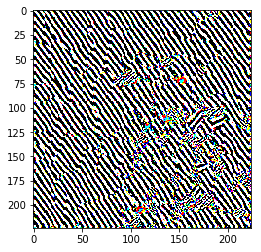

In [7]:
print('singular value', s)
print('perturbation p-norm', torch.norm(perturb, p).item()) # если берём p=inf, то всегда будем получать норму 1
normed_perturb = perturb.view(3, 224, 224).cpu() / torch.norm(perturb, p) * MAX_PERTURB_NORM
plt.imshow(process_image(normed_perturb))

In [8]:
orig_output = model(img_batch).cpu()
orig_probs, orig_preds = torch.softmax(orig_output, 1).max(1)

perturbed_output = model(img_batch + normed_perturb.to(device)).cpu()
perturbed_probs, perturbed_preds = torch.softmax(perturbed_output, 1).max(1)

print('rate of changed predictions', (orig_preds != perturbed_preds).float().mean().item())

rate of changed predictions 0.6200000047683716


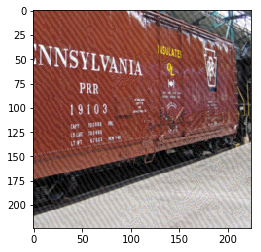

In [9]:
plt.imshow(process_image(img_batch[-1].cpu() + normed_perturb))

In [17]:
model.features[:10]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)